In [2]:
from oggm import cfg
from oggm import tasks, utils, workflow, graphics, DEFAULT_BASE_URL
import salem
import xarray as xr
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

In [3]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')

# Local working directory (where OGGM will write its output)
# WORKING_DIR = utils.gettempdir('OGGM_distr4')
cfg.PATHS['working_dir'] = '/mnt/d/lidar/ali/area/same_boundary'
cfg.PARAMS['border'] = 10
rgi_ids = ['RGI60-13.51473']
gdirs = workflow.init_glacier_directories(rgi_ids, prepro_base_url=DEFAULT_BASE_URL, from_prepro_level=4, prepro_border=80)

2025-07-12 08:13:37: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-07-12 08:13:37: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-07-12 08:13:37: oggm.cfg: Multiprocessing: using all available processors (N=24)


2025-07-12 08:13:41: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-07-12 08:13:42: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2025-07-12 08:13:42: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


In [16]:
# Do a random run with a bit of warming
workflow.execute_entity_task(
    tasks.run_random_climate,
    gdirs,
    ys=2020, ye=2500,  # Although the simulation is idealised, lets use real dates for the animation
    y0=2009, halfsize=10,  # Random climate of 1999-2019
    seed=1,  # Random number generator seed 
    temperature_bias=1.5,  # additional warming - change for other scenarios
    store_fl_diagnostics=True,  # important! This will be needed for the redistribution
    init_model_filesuffix='_spinup_historical',  # start from the spinup run
    output_filesuffix='_random_s1',  # optional - here I just want to make things explicit as to which run we are using afterwards
);

2025-07-12 21:19:48: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers


In [17]:
from oggm.sandbox import distribute_2d

In [18]:
# This is to add a new topography to the file (smoothed differently)
workflow.execute_entity_task(distribute_2d.add_smoothed_glacier_topo, gdirs)
# This is to get the bed map at the start of the simulation
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs)
# This is to prepare the glacier directory for the interpolation (needs to be done only once)
workflow.execute_entity_task(distribute_2d.assign_points_to_band, gdirs);

2025-07-12 21:19:52: oggm.workflow: Execute entity tasks [add_smoothed_glacier_topo] on 1 glaciers
2025-07-12 21:19:52: oggm.workflow: Execute entity tasks [distribute_thickness_per_altitude] on 1 glaciers
2025-07-12 21:19:53: oggm.workflow: Execute entity tasks [assign_points_to_band] on 1 glaciers


In [19]:
gdir = gdirs[0]  # here for Aletsch
#gdir = gdirs[1]  # uncomment for Fieschergletscher

with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()

In [20]:
ds = workflow.execute_entity_task(
    distribute_2d.distribute_thickness_from_simulation,
    gdirs, 
    input_filesuffix='_random_s1',  # Use the simulation we just did
    concat_input_filesuffix='_spinup_historical',  # Concatenate with the historical spinup
    output_filesuffix='',  # filesuffix added to the output filename gridded_simulation.nc, if empty input_filesuffix is used
)

2025-07-12 21:19:55: oggm.workflow: Execute entity tasks [distribute_thickness_from_simulation] on 1 glaciers


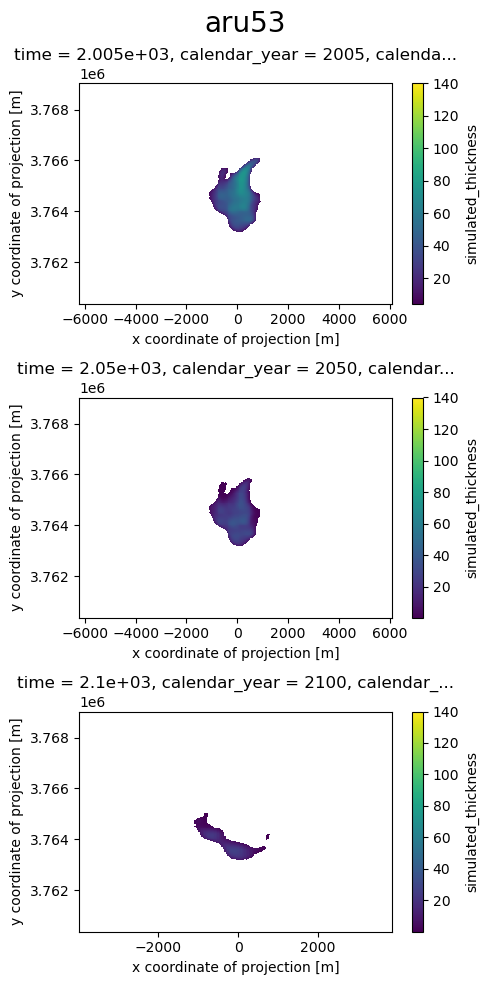

In [ ]:
def plot_distributed_thickness(ds, title):
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 10))
    ds.simulated_thickness.sel(time=2020).plot(ax=ax1, vmax=140);
    ds.simulated_thickness.sel(time=2050).plot(ax=ax2, vmax=140);
    ds.simulated_thickness.sel(time=2100).plot(ax=ax3, vmax=140);
    ax1.axis('equal'); ax2.axis('equal'); f.suptitle(title, fontsize=20);
    plt.tight_layout();

plot_distributed_thickness(ds[0], 'aru53')
# plot_distributed_thickness(ds[1], 'Fieschergletscher')  

In [1]:
def plot_area(ds, gdir, title):
    area = (ds.simulated_thickness > 0).sum(dim=['x', 'y']) * gdir.grid.dx**2 * 1e-6
    area.plot(label='Distributed area');
    plt.hlines(gdir.rgi_area_km2, gdir.rgi_date, 2100, color='C3', linestyles='--', label='RGI Area');
    plt.legend(loc='lower left'); plt.ylabel('Area [km2]'); plt.title(title, fontsize=20); plt.show();


plot_area(ds[0], gdirs[0], 'Aru53')
# plot_area(ds[1], gdirs[1], 'Fieschergletscher')

NameError: name 'ds' is not defined

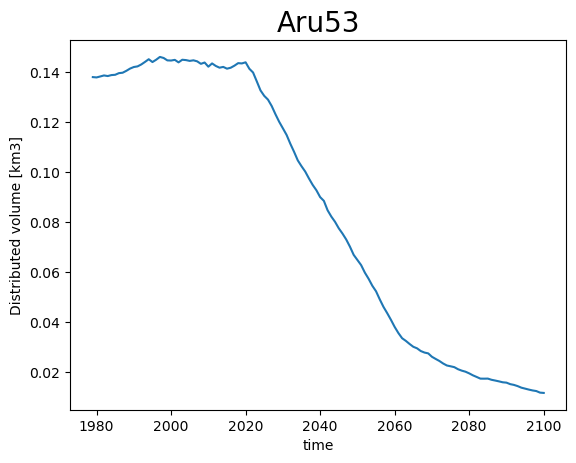

In [15]:
def plot_volume(ds, gdir, title):
    vol = ds.simulated_thickness.sum(dim=['x', 'y']) * gdir.grid.dx**2 * 1e-9
    vol.plot(label='Distributed volume'); plt.ylabel('Distributed volume [km3]');
    plt.title(title, fontsize=20); plt.show();


plot_volume(ds[0], gdirs[0], 'Aru53')
# plot_volume(ds[1], gdirs[1], 'Fieschergletscher')